In [2]:
# import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis 
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave
import matplotlib.patches as mpatches
from random import choice
import matplotlib as mpl
from amftrack.pipeline.final_analysis.density_wave import plot_single_plate,plot_single_plate_biovolume
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
from amftrack.util.plot import gridplot, make_stat
from helper import *
from load_dataframes import load_all
from plates import plates,timestep
%store -r path_figure
%matplotlib widget
%load_ext autoreload
%autoreload 2
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy
import statsmodels.api as sm
import hashlib
from matplotlib.patches import Ellipse
import logging
plt.style.use('presentation.mplstyle')
logging.getLogger().setLevel(logging.WARNING)




c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
path_figure = r"C:\Users\coren\Documents\PhD\paper\PandC\Fig4"


In [4]:
df,final_data = load_all(plates)

C:\Users\coren\Documents\PhD\Code\pycode\P_depletion_paper\final_figures\load_dataframes.py:111: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_sum['start'] = pd.to_datetime(df_sum['start'], errors='coerce')
C:\Users\coren\Documents\PhD\Code\pycode\P_depletion_paper\final_figures\load_dataframes.py:112: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_sum['crossed']  = pd.to_datetime(df_sum['crossed'], errors='coerce')
C:\Users\coren\Documents\PhD\Code\pycode\P_depletion_paper\final_figures\load_dataframes.py:113: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsi

In [5]:
Vmax = 3.8e-9 #ugP/um2/hour
density = 1e-6 #ug/um3
dry_wet_ratio = 0.3
carbon_ratio = 0.5
carbon_ratio_spore = 0.9
dry_wet_ratio_spore = 0.9
density_spore = 0.9e-6
respiration_ratio = 0.5

In [6]:
def calculate_derivative(df, column, new_column, window=1):
    # Ensure the DataFrame is sorted by 'unique_id' and 'time_since_begin_h'
    df.sort_values(by=['unique_id', 'time_since_begin_h'], inplace=True)
    
    # Calculate the time difference and value difference over the desired window
    df['time_diff'] = df.groupby('unique_id')['time_since_begin_h'].transform(lambda x: x.diff(window)).fillna(0)
    df['value_diff'] = df.groupby('unique_id')[column].transform(lambda x: x.diff(window)).fillna(0)

    # Calculate the derivative (value difference divided by time difference)
    # Be cautious about dividing by zero. If 'time_diff' is 0, set derivative to NaN or handle accordingly.
    df[new_column] = df.apply(lambda x: x['value_diff'] / x['time_diff'] if x['time_diff'] != 0 else None, axis=1)

    # Drop the helper columns
    df.drop(['time_diff', 'value_diff'], axis=1, inplace=True)
def calculate_integral(df, column, new_column):
    # Calculate the time difference within each group
    df.sort_values(by=['unique_id', 'time_since_begin_h'], inplace=True)
    df['time_since_begin_hour'] = df['time_since_begin_h']
    df['time_diff'] = df.groupby('unique_id')['time_since_begin_hour'].transform(lambda x: x.diff())

    # Calculate the average length density within each group
    df['avg_length_density'] = df.groupby('unique_id')[column].transform(lambda x: x.rolling(window=2).mean())

    # Calculate the "area" (using Trapezoidal rule) for each pair of rows within each group
    df['area'] = df['time_diff'] * df['avg_length_density']

    # Perform the integration (cumulative sum of "area") within each group
    df[new_column] = df.groupby('unique_id')['area'].transform(lambda x: x.cumsum())

    # Drop the helper columns if needed
    df.drop(['time_diff', 'avg_length_density', 'area'], axis=1, inplace=True)
baseline = final_data[final_data['time_since_begin_h'] == 0]

# Step 2: Create a series with spore_volume at time_since_begin_h = 0 for each unique_id
baseline_volume = baseline.groupby('unique_id')['spore_volume'].first()
final_data['adjusted_spore_volume'] = final_data.groupby('unique_id')['spore_volume'].transform(lambda x: x - baseline_volume[x.name])

final_data['totC_hypha'] = final_data['tot_biovolume_study']*density*dry_wet_ratio*carbon_ratio
final_data['tot_volume'] = final_data['adjusted_spore_volume']+final_data['tot_biovolume_study']
final_data['totC_spore'] = final_data['adjusted_spore_volume']*density_spore*dry_wet_ratio_spore*carbon_ratio_spore
final_data['totC_tot'] = final_data['totC_hypha'] + final_data['totC_spore']
calculate_integral(final_data,f'tot_surface_area_study',f'integrated_SA')
calculate_derivative(final_data,f'tot_volume',f'derivative_biovolume', window=5)
calculate_derivative(final_data,f'derivative_biovolume',f'acceleration_biovolume', window=5)

calculate_derivative(final_data,f'tot_volume',f'derivative_tot_biovolume', window=5)



# Step 3: Subtract this baseline value from each row's spore_volume
final_data['P_rate'] =final_data['tot_surface_area_study']*Vmax
final_data['C_rate'] = final_data['derivative_biovolume']*density*dry_wet_ratio*carbon_ratio/respiration_ratio


tmax = 60
final_data = final_data.reset_index(drop=True)

select_data = final_data.loc[final_data['time_since_begin_h_shifted']<=tmax]
select_data = select_data.loc[select_data['unique_id']!=44720230821] #gives error

select_data = select_data.reset_index(drop=True)

max_c_rate_time = select_data.loc[select_data.groupby('unique_id')['C_rate'].idxmax(), ['unique_id', 'time_since_begin_h_shifted']]

# Step 2: Merge this information back to the original DataFrame
select_data = select_data.merge(max_c_rate_time, on='unique_id', suffixes=('', '_max_c_rate'))
num_bin =20
select_data['cat_P_rate']= pd.cut(select_data['P_rate'],num_bin)
def get_bin_midpoint(bin):
    if pd.isna(bin):
        return None
    lower, upper = bin.left, bin.right
    return (lower + upper) / 2

select_data['cat_P_rate'] = select_data['cat_P_rate'].apply(get_bin_midpoint)
select_data['rootXstrain'] = select_data['real_root']+'_'+select_data['strain']

# Step 3: Filter rows where time_since_begin_h is less than the time at max C_rate
# selected_data = final_data[final_data['time_since_begin_h'] < final_data['time_since_begin_h_max_c_rate']]

In [7]:
n_colors = len(df['fungus'].unique())

palette = sns.color_palette("rainbow", n_colors)
strain_to_color = dict(zip(df['fungus'].unique(), palette))

2024-01-25 20:00:18,318-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


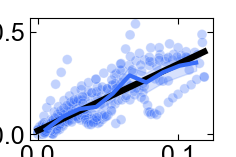

In [8]:
cm = 1/2.54  # centimeters in inches
fig,ax = plt.subplots(figsize = (6*cm,4*cm))

select = select_data
select = select_data[select_data['time_since_begin_h_shifted'] < select_data['time_since_begin_h_shifted_max_c_rate']]
select = select[select['C_rate']>0]
# select = select[select['P_rate']<=2.9]
select = select[select['time_hour_binned'] <= 50]
select = select[select['real_root']=="Carrot Vasilis"]
select = select[select['strain']=="C2"]
grouped = select.groupby('cat_P_rate')
filtered_groups = grouped.filter(lambda x: x['unique_id'].nunique() >= 5)
select = filtered_groups

sns.scatterplot(data=select,x='P_rate',y='C_rate',hue="strain",size = 5,alpha = 0.3,legend=False,palette=strain_to_color)
sns.regplot(data=select,x='P_rate',y='C_rate',scatter=False,ci = None,color = 'black')

sns.lineplot(data=select,x='cat_P_rate',y='C_rate',estimator = "mean",color="red",palette=strain_to_color,hue="strain")
ax.set_ylabel('$\Phi_C$ \n ($\mu g/h$)')
ax.set_xlabel('$\Phi_P$ ($\mu g/h$)')

plt.legend().remove()

plt.savefig(os.path.join(path_figure,'Figure4A.pdf'), transparent=True, bbox_inches='tight')


In [25]:
slope2, intercept, r_value, p_value, std_err = stats.linregress(subset['P_rate'], subset['C_rate'])
slope2,std_err

(1.5691773284867854, 0.7843909938060133)

2024-01-25 20:04:39,368-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


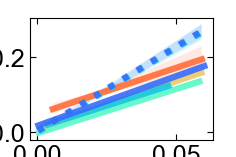

In [19]:
n_colors = len(df['fungus'].unique())

palette = sns.color_palette("rainbow", n_colors)
strain_to_color = dict(zip(df['fungus'].unique(), palette))
linestyles = ['-',':']
root_to_linestyle = {'Carrot Toby': linestyles[0], 'Carrot Vasilis': linestyles[1]}

select = select_data
select = select_data[select_data['time_since_begin_h_shifted'] < select_data['time_since_begin_h_shifted_max_c_rate']]
# select = select[select['real_root']=='Carrot Toby']

select = select[select['C_rate']>0]
select = select[select['fungalC']=='100P/100N/100C']

select = select[select['P_rate']<=1.5/25]
select = select[select['P_rate']>0]
# select = select[select['C_rate']>0.01]
# select = select[select['P_rate']>0.1]

# select = select[select['strain'].isin(['C2','A5','Agg','Clarum'])]
select = select[select['real_root'].isin(['Carrot Toby','Carrot Vasilis'])]
fig,ax = plt.subplots(figsize = (6*cm,4*cm))

# Loop through each category and plot a regplot for each
for category in select['rootXstrain'].unique():
    subset = select[select['rootXstrain'] == category]
    fungus = subset['strain'].iloc[0]
    real_root = subset['real_root'].iloc[0]  # Extract real_root value from the subset
    linestyle = root_to_linestyle[real_root]  # Get the linestyle based on real_root
    grouped = subset.groupby('cat_P_rate')
    filtered_groups = grouped.filter(lambda x: x['unique_id'].nunique() >= 2)
    # sns.scatterplot(data=subset,x='P_rate',y='C_rate',size = 5,alpha = 0.3,legend=False,ax = ax,color=strain_to_color[fungus])
    sns.regplot(data=filtered_groups,x='P_rate',y='C_rate',ax=ax,color=strain_to_color[fungus],line_kws={'linestyle' : linestyle,"alpha" : 0.9},scatter = False)

    # sns.lineplot(data=subset,x='cat_P_rate',y='C_rate',estimator = "mean",ax=ax,color=strain_to_color[fungus],linestyle = linestyle)
ax.set_ylabel('$\Phi_C$ \n ($\mu g/h$)')
ax.set_xlabel('$\Phi_P$ ($\mu g/h$)')
# ax.set_xscale('logit')
# ax.set_yscale('logit')
# ax.set_ylim(0.02,0.5)
plt.savefig(os.path.join(path_figure,'Figure4B.pdf'), transparent=True, bbox_inches='tight')


In [10]:
def zero_regplot(data, x, y, ax, label, scatter=True, n_boot=1000, color=None,linestyle=None):
    # Extract x and y data
    x_data = data[x]
    y_data = data[y]

    # Bootstrap resampling
    bootstrapped_slopes = []
    for _ in range(n_boot):
        # Resample with replacement
        resampled_indices = np.random.choice(range(len(x_data)), size=len(x_data), replace=True)
        resampled_x = x_data.iloc[resampled_indices]
        resampled_y = y_data.iloc[resampled_indices]

        # Fit a line through the origin
        slope = np.sum(resampled_x * resampled_y) / np.sum(resampled_x * resampled_x)
        bootstrapped_slopes.append(slope)

    # Calculate slope and confidence intervals
    bootstrapped_slopes = np.array(bootstrapped_slopes)
    slope_estimate = bootstrapped_slopes.mean()
    ci_lower = np.nanpercentile(bootstrapped_slopes, 2.5)
    ci_upper = np.nanpercentile(bootstrapped_slopes, 97.5)

    # Create regression line
    x_vals = x_data
    y_vals = slope_estimate * x_vals
    # Plot
    if scatter:
        ax.scatter(x_data, y_data, alpha=0.7,s=3,color=color)
    ax.plot(x_vals, y_vals, color=color, label=f'{label} Slope: {slope_estimate:.2f}',linestyle=linestyle)
    # print(ci_lower , ci_upper ,label)
    ax.fill_between(x_vals, ci_lower * x_vals, ci_upper * x_vals, color=color, alpha=0.2)

    # Set labels and legend
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.legend()

In [11]:
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis, get_time_plate_info_long_from_analysis
all_analysis_folders = get_analysis_folders()
#for P
plates = [
"416_20230705",
"427_20230707",
"420_20230705",
"431_20230627",
"474_20230807",
"460_20230807",
"464_20230807",
"440_20230723",
"436_20230717",
"443_20230720",
"439_20230804",
"470_20230709",
'478_20230814', '468_20230809', '447_20230821', '487_20230922',
       '492_20230901', '471_20230821', '486_20231009',
       '494_20230908', '482_20230908', '495_20231013', '463_20231013',
       '491_20231013', '481_20231005', '483_20231005',
    '490_20231003',
       '485_20230929',
]
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]
folders,time_plate_info = get_time_plate_info_long_from_analysis(analysis_folders,False)
def calculate_integral(df, column, new_column):
    # Calculate the time difference within each group
    df['time_since_begin_hour'] = df['time_since_begin_h'].dt.total_seconds() / 3600.0
    df['time_diff'] = df.groupby('unique_id')['time_since_begin_hour'].transform(lambda x: x.diff())

    # Calculate the average length density within each group
    df['avg_length_density'] = df.groupby('unique_id')[column].transform(lambda x: x.rolling(window=2).mean())

    # Calculate the "area" (using Trapezoidal rule) for each pair of rows within each group
    df['area'] = df['time_diff'] * df['avg_length_density']

    # Perform the integration (cumulative sum of "area") within each group
    df[new_column] = df.groupby('unique_id')['area'].transform(lambda x: x.cumsum())

    # Drop the helper columns if needed
    df.drop(['time_diff', 'avg_length_density', 'area'], axis=1, inplace=True)
for i in range(18):
    calculate_integral(time_plate_info,f'SA_region_{i}',f'integrated_SA_{i}')
for i in range(18):
    calculate_integral(time_plate_info,f'length_density_region_{i}',f'integrated_L_{i}')


In [12]:
C_max2 = 1.53

def fit_function(x, C_max):
    return 1+C_max * 1/x**(3/2)
# Read the Excel file
path = r'C:\Users\coren\Documents\PhD\Pexperiment'
path_excel = os.path.join(path,'summary.xlsx')
df_P = pd.read_excel(path_excel)
df_P['date_from_unique_id'] = pd.to_datetime(df_P['unique_id'].str.split('_').str[1], format='%Y%m%d')
    
# Convert 'day' column to datetime
df_P['day_sample'] = pd.to_datetime(df_P['day_sample'], format='%Y%m%d')  # Update the format as necessary
df_P['day_start'] = pd.to_datetime(df_P['start'], format='%Y%m%d')  # Update the format as necessary

df_P['time_elapsed'] = df_P['day_sample'] - df_P['day_start']
df_P['time_elapsed_day'] = df_P['time_elapsed'].dt.days
df_P['time_since_crossing'] = df_P['day_sample'] - df_P['date_from_unique_id']
df_P['t2 (day)'] = df_P['time_since_crossing'].dt.days
df_P['t1 (day)'] = df_P['time_elapsed_day']-df_P['t2 (day)']
df_P['treatment'] = df_P['treatment'].fillna('none')
df_P['wet_weight_measured'] = df_P['wet weight']

df_P['wet weight'] = df_P['wet weight']-df_P['lost weight']
df_P['totP (ug)'] = df_P['totP (ug)'] * fit_function(df_P['totP (ug)'], C_max2)
df_P['Sample_name'] = df_P['Sample_name'].str.replace('bottom','0')
df_P['Sample_name'] = df_P['Sample_name'].str.replace('up','1')
df_P['Sample_name'] = df_P['Sample_name'].str.replace('top','1')
df_P['Sample_name'] = df_P['Sample_name'].str.replace('agar','0')



df_P = df_P.loc[df_P['plate']!=487]
df_P = df_P.loc[df_P['type'] == 'agar']
df_P['pos'] = df_P['Sample_name'].str.split('-').str.get(1).astype(int)

In [13]:
from plates import plates as plates2
df_sum,smallP = load_all(plates2)
smallP['time_since_begin_hour'] = smallP['time_since_begin_h'] / 3600.0


C:\Users\coren\Documents\PhD\Code\pycode\P_depletion_paper\final_figures\load_dataframes.py:111: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_sum['start'] = pd.to_datetime(df_sum['start'], errors='coerce')
C:\Users\coren\Documents\PhD\Code\pycode\P_depletion_paper\final_figures\load_dataframes.py:112: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_sum['crossed']  = pd.to_datetime(df_sum['crossed'], errors='coerce')
C:\Users\coren\Documents\PhD\Code\pycode\P_depletion_paper\final_figures\load_dataframes.py:113: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsi

In [14]:
def calculate_derivative(df, column, new_column, window=1):
    # Ensure the DataFrame is sorted by 'unique_id' and 'time_since_begin_h'
    df.sort_values(by=['unique_id', 'time_since_begin_h'], inplace=True)
    
    # Calculate the time difference and value difference over the desired window
    df['time_diff'] = df.groupby('unique_id')['time_since_begin_h'].transform(lambda x: x.diff(window)).fillna(0)
    df['value_diff'] = df.groupby('unique_id')[column].transform(lambda x: x.diff(window)).fillna(0)

    # Calculate the derivative (value difference divided by time difference)
    # Be cautious about dividing by zero. If 'time_diff' is 0, set derivative to NaN or handle accordingly.
    df[new_column] = df.apply(lambda x: x['value_diff'] / x['time_diff'] if x['time_diff'] != 0 else None, axis=1)

    # Drop the helper columns
    df.drop(['time_diff', 'value_diff'], axis=1, inplace=True)
def calculate_integral(df, column, new_column):
    # Calculate the time difference within each group
    df.sort_values(by=['unique_id', 'time_since_begin_h'], inplace=True)
    df['time_since_begin_hour'] = df['time_since_begin_h']
    df['time_diff'] = df.groupby('unique_id')['time_since_begin_hour'].transform(lambda x: x.diff())

    # Calculate the average length density within each group
    df['avg_length_density'] = df.groupby('unique_id')[column].transform(lambda x: x.rolling(window=2).mean())

    # Calculate the "area" (using Trapezoidal rule) for each pair of rows within each group
    df['area'] = df['time_diff'] * df['avg_length_density']

    # Perform the integration (cumulative sum of "area") within each group
    df[new_column] = df.groupby('unique_id')['area'].transform(lambda x: x.cumsum())

    # Drop the helper columns if needed
    df.drop(['time_diff', 'avg_length_density', 'area'], axis=1, inplace=True)
final_data = smallP
    
calculate_integral(final_data,f'tot_surface_area_study',f'integrated_SA')
calculate_derivative(final_data,f'tot_biovolume_study',f'derivative_biovolume', window=5)
calculate_derivative(final_data,f'tot_volume',f'derivative_tot_biovolume', window=5)

Vmax = 3e-9*25 #ugP/um2/hour
density = 1e-6 #ug/um3
dry_wet_ratio = 0.3
carbon_ratio = 0.5
carbon_ratio_spore = 0.9
dry_wet_ratio_spore = 0.9
density_spore = 0.9e-6
respiration_ratio = 0.5
final_data['P_rate'] =final_data['tot_surface_area_study']*Vmax
final_data['C_rate'] = final_data['derivative_biovolume']*density*dry_wet_ratio*carbon_ratio/respiration_ratio
final_data['totC_hypha'] = final_data['tot_biovolume_study']*density*dry_wet_ratio*carbon_ratio
final_data['tot_volume'] = final_data['spore_volume']+final_data['tot_biovolume_study']
final_data['totC_spore'] = final_data['spore_volume']*density_spore*dry_wet_ratio_spore*carbon_ratio_spore
final_data['totC_tot'] = final_data['totC_hypha'] + final_data['totC_spore']

final_data = final_data.reset_index(drop=True)
final_data_select = final_data.loc[final_data['time_since_begin_h_shifted']<=150]

max_c_rate_time = final_data_select.loc[final_data_select.groupby('unique_id')['C_rate'].idxmax(), ['unique_id', 'time_since_begin_h_shifted']]

# Step 2: Merge this information back to the original DataFrame
final_data = final_data.merge(max_c_rate_time, on='unique_id', suffixes=('', '_max_c_rate'))
calculate_derivative(final_data,f'tot_surface_area_study',f'derivative_SA', window=5)
calculate_derivative(final_data,f'totC_tot',f'derivative_C', window=5)

calculate_derivative(final_data,f'area_sep_comp',f'derivative_area', window=5)
final_data['instant_SA_dens'] = final_data['derivative_SA']/final_data['derivative_area']
calculate_derivative(final_data,f'tot_biovolume_study',f'derivative_BV', window=5)
final_data['instant_BV_dens'] = final_data['derivative_BV']/final_data['derivative_area']
calculate_derivative(final_data,f'tot_length_study',f'derivative_L', window=5)
final_data['instant_L_dens'] = final_data['derivative_L']/final_data['derivative_area']
final_data['instant_C_dens'] = final_data['derivative_C']/final_data['derivative_area']

final_data['instant_radius'] = final_data['instant_BV_dens']/final_data['instant_SA_dens']*2


In [15]:
selection = final_data[final_data['strain']=="C2"]
selection = selection[selection['real_root']=='Carrot Vasilis']
selection = selection[selection['treatment']=="1P/100N/100C"]
# selection = selection[~selection['unique_id'].isin([468_20230809])]
selection['instant_C_dens']

3599         NaN
3600         NaN
3601         NaN
3602         NaN
3603         NaN
          ...   
9381    0.021070
9382    0.000170
9383    0.007086
9384    0.001064
9385    0.138457
Name: instant_C_dens, Length: 2018, dtype: float64

2024-01-25 20:01:26,467-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


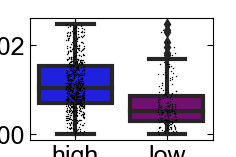

In [16]:
cm = 1/2.54  # centimeters in inches

# selection = df_sum[df_sum['FungalSide']=='0P/100N/100C']
selection = final_data[final_data['strain']=="C2"]
selection = selection[selection['real_root']=='Carrot Vasilis']
selection = selection[selection['treatment']=="1P/100N/100C"]
selection = selection[~selection['unique_id'].isin([468_20230809])]
selection= selection[selection['instant_C_dens']>0]
selection= selection[selection['instant_C_dens']<=0.025].copy()
first_category = selection["fungalC"].unique()[0]

palette = {category: "blue" if category == first_category else "purple" for category in selection["fungalC"].unique()}
fig,ax = plt.subplots(figsize = (6*cm,4*cm))
sns.boxplot(data=selection, y="instant_C_dens", x="fungalC", palette=palette)
sns.stripplot(selection,y="instant_C_dens",x = "fungalC",color= "black",size=1)
ax.set_ylabel('$d_{Carbon}$ \n ($mm^3/mm^2$)')
ax.set_xlabel('$C_{P,0,fungal}$')
ax.set_xticklabels(['high', 'low'])
plt.savefig(os.path.join(path_figure,'Figure4C.pdf'), transparent=True, bbox_inches='tight')

# plt.tight_layout()

In [17]:
merged_df = pd.merge(smallP, time_plate_info, on=['folder','unique_id','folder'], how='left')

In [20]:
slope = -3.3973588349543932e-09

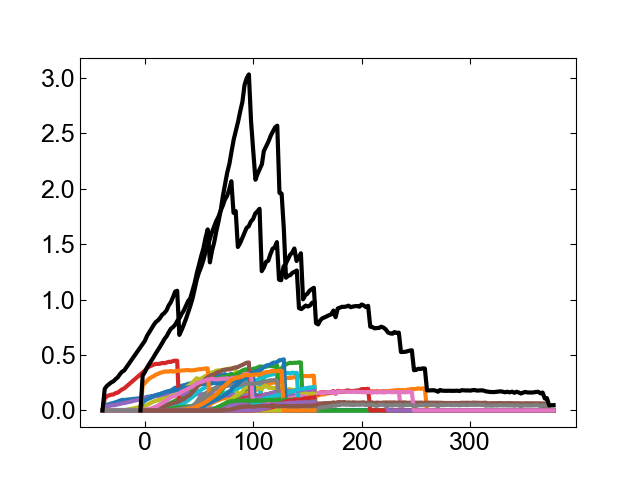

In [21]:
unique_ids = merged_df['unique_id'].unique()
unique_ids = ['471_20230821','474_20230807']
fig,ax = plt.subplots()
# Loop through each unique ID and plot the data
maxCP = 0.6
for unique_id in unique_ids:
    # Filter the DataFrame for the current unique ID
    df_subset = merged_df[merged_df['unique_id'] == int(unique_id)].copy()
    # Extract the relevant columns
    time_since_begin_h = df_subset['time_since_begin_h_shifted']
    select = df_P[df_P['arrangement'] == 'basic']
    
    for i in range(18):
        subselect = select[select['pos']==i+1]
        C_P = maxCP+df_subset[f'integrated_SA_{i}']/np.mean(subselect['wet weight'])*slope
        # rate_P =  (C_P>0)*(C_P/maxCP)*df_subset[f'SA_region_{i}']*Vmax
        rate_P =  (C_P>0)*df_subset[f'SA_region_{i}']*Vmax
        
        df_subset.loc[df_subset['unique_id'] == int(unique_id), f'C_P_{i}'] = C_P
        df_subset.loc[df_subset['unique_id'] == int(unique_id), f'P_rate_{i}'] =rate_P
            # Create a plot for the current unique ID
        ax.plot(time_since_begin_h, rate_P, label=f'ID {unique_id}')
    p_rate_columns = [f'P_rate_{i}' for i in range(18)]
    merged_df.loc[merged_df['unique_id'] == int(unique_id), 'sum_P_rate'] = df_subset[p_rate_columns].sum(axis=1)
    ax.plot(time_since_begin_h, merged_df.loc[merged_df['unique_id'] == int(unique_id), 'sum_P_rate'], label=f'ID {unique_id}',color="black")
    
# Identify overlapping columns, excluding the keys used for merging
overlapping_columns = [col for col in merged_df.columns if col in final_data.columns and col not in ['folder', 'unique_id', 'time_since_begin_hour']]

# Drop these columns from the right dataframe
merged_df_dropped = merged_df.drop(columns=overlapping_columns)

# Perform the merge
select_data_merge = pd.merge(final_data, merged_df_dropped, on=['folder', 'unique_id', 'folder'], how='left')

2024-01-25 20:05:07,458-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


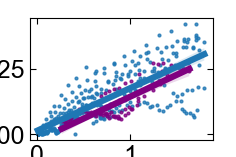

In [22]:
n_colors = len(df_sum['fungus'].unique())

palette = sns.color_palette("rainbow", n_colors)
strain_to_color = dict(zip(df_sum['fungus'].unique(), palette))
linestyles = ['-',':']
root_to_linestyle = {'Carrot Toby': linestyles[0], 'Carrot Vasilis': linestyles[1]}

select = select_data_merge[select_data_merge['time_since_begin_h_shifted'] < select_data_merge['time_since_begin_h_shifted_max_c_rate']]
# select = select[select['real_root']=='Carrot Toby']

select = select[select['C_rate']>0]

select = select[select['P_rate']<=1.8]
select = select[select['P_rate']>0]
# select = select[select['real_root']=='Carrot Toby']


select = select[select['strain'].isin(['C2'])]
select = select[select['real_root'].isin(['Carrot Vasilis'])]
select = select[~select['unique_id'].isin([468_20230809])]




fig,ax = plt.subplots(figsize = (6*cm,4*cm))
# fig,ax = plt.subplots()

# Loop through each category and plot a regplot for each
for category in select['fungalC'].unique():
    subset = select[select['fungalC'] == category]
    fungus = subset['strain'].iloc[0]
    real_root = subset['real_root'].iloc[0]  # Extract real_root value from the subset
    linestyle = root_to_linestyle[real_root]  # Get the linestyle based on real_root
    if category =='100P/100N/100C':
        # zero_regplot(data=subset, x='P_rate', y='C_rate', ax=ax, label=category,scatter =True)
        sns.regplot(data=subset, x='P_rate', y='C_rate', ax=ax, label=category,scatter =True,scatter_kws={"s":4})
        
    else:
        # zero_regplot(data=subset, x='sum_P_rate', y='C_rate', ax=ax, label=category,scatter =True,color = "purple")
        sns.regplot(data=subset, x='sum_P_rate', y='C_rate', ax=ax, label=category,scatter =True,scatter_kws={"s":4},color="purple")

ax.set_ylabel('$\Phi_C$ \n ($\mu g/h$)')
ax.set_xlabel('$\Phi_P$ ($\mu g/h$)')

plt.legend().remove()
plt.savefig(os.path.join(path_figure,'Figure4D.pdf'), transparent=True, bbox_inches='tight')

# plt.tight_layout()

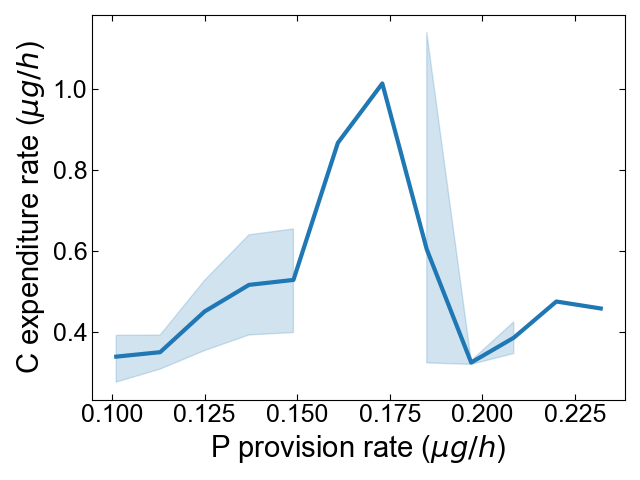

In [23]:

n_colors = len(df['fungus'].unique())

palette = sns.color_palette("rainbow", n_colors)
strain_to_color = dict(zip(df['fungus'].unique(), palette))
linestyles = ['-',':']
root_to_linestyle = {'Carrot Toby': linestyles[0], 'Carrot Vasilis': linestyles[1]}

select = select_data
select = select_data[select_data['time_since_begin_h_shifted'] < select_data['time_since_begin_h_shifted_max_c_rate']]
# select = select[select['real_root']=='Carrot Toby']

select = select[select['C_rate']>0]

select = select[select['P_rate']<=1.3]
select = select[select['P_rate']>0.1]

select = select[select['strain'].isin(['C2'])]
select = select[select['real_root'].isin(['Carrot Vasilis'])]
fig, ax = plt.subplots()

# Loop through each category and plot a regplot for each
for category in select['fungalC'].unique():
    subset = select[select['fungalC'] == category]

    # sns.scatterplot(data=subset,x='P_rate',y='C_rate',size = 5,alpha = 0.3,legend=False,ax = ax,color=strain_to_color[fungus])

    sns.lineplot(data=subset,x='cat_P_rate',y='C_rate',estimator = "mean",ax=ax)
ax.set_ylabel('C expenditure rate ($\mu g/h$)')
ax.set_xlabel('P provision rate ($\mu g/h$)')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim(0.02,0.5)
plt.tight_layout()


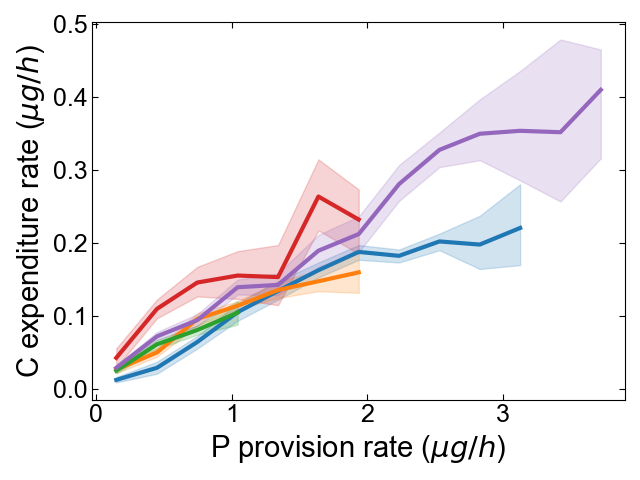

In [21]:

select = select_data
select = select_data[select_data['time_since_begin_h_shifted'] < select_data['time_since_begin_h_shifted_max_c_rate']]
select = select[select['C_rate']>0]
# select = select[select['P_rate']<=3]
select = select[select['P_rate']>0]
select = select[select['real_root']=='Carrot Toby']




fig, ax = plt.subplots()

# Loop through each category and plot a regplot for each
for category in select['strain'].unique():
    subset = select[select['strain'] == category]
    grouped = subset.groupby('cat_P_rate')
    filtered_groups = grouped.filter(lambda x: x['unique_id'].nunique() >= 2)

    sns.lineplot(data=filtered_groups,x='cat_P_rate',y='C_rate',estimator = "mean",ax=ax)
ax.set_ylabel('C expenditure rate ($\mu g/h$)')
ax.set_xlabel('P provision rate ($\mu g/h$)')
plt.tight_layout()


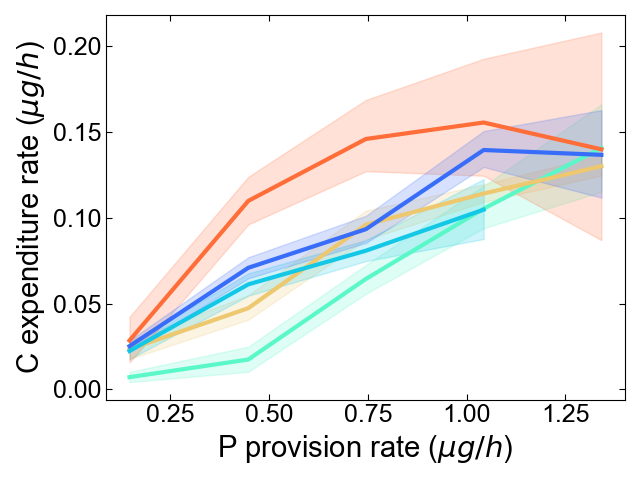

In [22]:
n_colors = len(df['fungus'].unique())

palette = sns.color_palette("rainbow", n_colors)
strain_to_color = dict(zip(df['fungus'].unique(), palette))
linestyles = ['-',':']
root_to_linestyle = {'Carrot Toby': linestyles[0], 'Carrot Vasilis': linestyles[1]}

select = select_data
select = select_data[select_data['time_since_begin_h_shifted'] < select_data['time_since_begin_h_shifted_max_c_rate']]
# select = select[select['real_root']=='Carrot Toby']

# select = select[select['C_rate']>0]
select = select[select['fungalC']=='100P/100N/100C']

select = select[select['P_rate']<=1.3]
# select = select[select['P_rate']>0]

# select = select[select['strain'].isin(['C2','A5','Agg','Clarum'])]
select = select[select['real_root'].isin(['Carrot Toby','Carrot Vasilis'])]
select = select[select['real_root'].isin(['Carrot Toby'])]

fig, ax = plt.subplots()

# Loop through each category and plot a regplot for each
for category in select['rootXstrain'].unique():
    subset = select[select['rootXstrain'] == category]
    fungus = subset['strain'].iloc[0]
    real_root = subset['real_root'].iloc[0]  # Extract real_root value from the subset
    linestyle = root_to_linestyle[real_root]  # Get the linestyle based on real_root
    grouped = subset.groupby('cat_P_rate')
    filtered_groups = grouped.filter(lambda x: x['unique_id'].nunique() >= 2)
    # sns.scatterplot(data=subset,x='P_rate',y='C_rate',size = 5,alpha = 0.3,legend=False,ax = ax,color=strain_to_color[fungus])

    sns.lineplot(data=filtered_groups,x='cat_P_rate',y='C_rate',estimator = "mean",ax=ax,color=strain_to_color[fungus],linestyle = linestyle)
    # sns.regplot(data=filtered_groups,x='cat_P_rate',y='C_rate',ax=ax,color=strain_to_color[fungus],ci = None,scatter = False)
    
ax.set_ylabel('C expenditure rate ($\mu g/h$)')
ax.set_xlabel('P provision rate ($\mu g/h$)')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim(0.02,0.5)
plt.tight_layout()


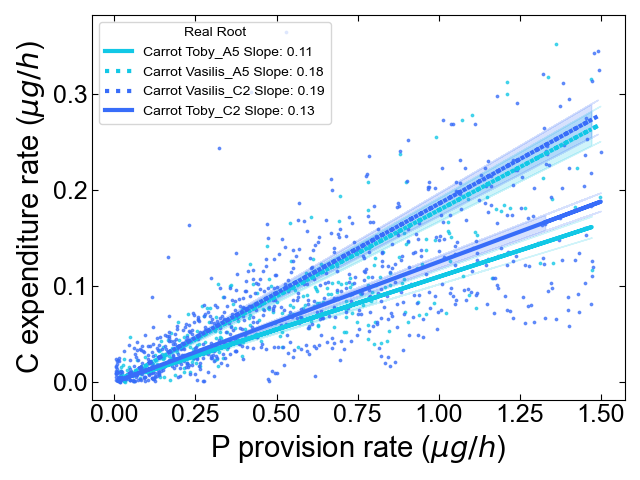

In [23]:
n_colors = len(df['fungus'].unique())

palette = sns.color_palette("rainbow", n_colors)
strain_to_color = dict(zip(df['fungus'].unique(), palette))
linestyles = ['-',':']
root_to_linestyle = {'Carrot Toby': linestyles[0], 'Carrot Vasilis': linestyles[1]}

select = select_data
select = select_data[select_data['time_since_begin_h_shifted'] < select_data['time_since_begin_h_shifted_max_c_rate']]
# select = select[select['real_root']=='Carrot Toby']

select = select[select['C_rate']>0]
select = select[select['P_rate']<=1.5]
select = select[select['P_rate']>0]
select = select[select['strain'].isin(['C2','A5'])]
select = select[select['real_root'].isin(['Carrot Toby','Carrot Vasilis'])]
select = select[select['fungalC']=='100P/100N/100C']




fig, ax = plt.subplots()

# Loop through each category and plot a regplot for each
for category in select['rootXstrain'].unique():
    subset = select[select['rootXstrain'] == category]
    fungus = subset['strain'].iloc[0]
    real_root = subset['real_root'].iloc[0]  # Extract real_root value from the subset
    linestyle = root_to_linestyle[real_root]  # Get the linestyle based on real_root
    zero_regplot(data=subset, x='P_rate', y='C_rate', ax=ax, label=category,scatter =True,color=strain_to_color[fungus],linestyle = linestyle)

# Setting labels and legend
ax.set_ylabel('C expenditure rate ($\mu g/h$)')
ax.set_xlabel('P provision rate ($\mu g/h$)')
ax.legend(title='Real Root')

plt.tight_layout()



In [24]:
select['fungalC'].unique()

array(['100P/100N/100C'], dtype=object)

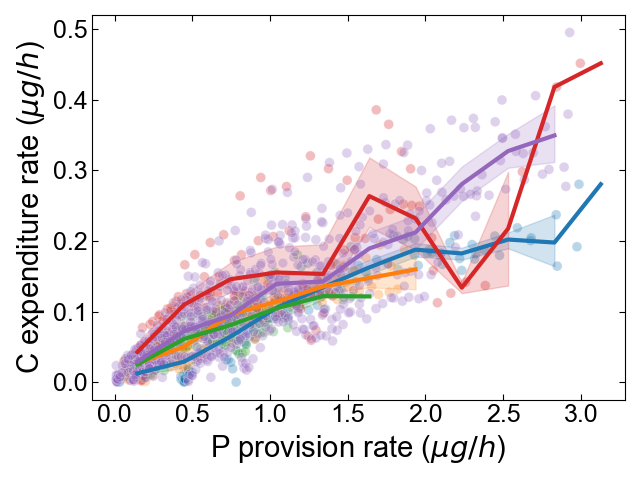

In [25]:

select = select_data
select = select_data[select_data['time_since_begin_h_shifted'] < select_data['time_since_begin_h_shifted_max_c_rate']]
select = select[select['C_rate']>0]
select = select[select['P_rate']<=3]
select = select[select['P_rate']>0]
select = select[select['real_root']=='Carrot Toby']




fig, ax = plt.subplots()

# Loop through each category and plot a regplot for each
for category in select['strain'].unique():
    subset = select[select['strain'] == category]

    sns.scatterplot(data=subset,x='P_rate',y='C_rate',size = 5,alpha = 0.3,legend=False,ax = ax)

    sns.lineplot(data=subset,x='cat_P_rate',y='C_rate',estimator = "mean",ax=ax)
ax.set_ylabel('C expenditure rate ($\mu g/h$)')
ax.set_xlabel('P provision rate ($\mu g/h$)')
plt.tight_layout()


In [26]:
from scipy.stats import linregress


slopes = []  # to store the slopes for each unique_id
lengths = []
for unique_id in df['unique_id']:
    # Filter the data for the current unique_id
    select = select_data[select_data['unique_id'] == int(unique_id)]
    select = select[select['time_since_begin_h_shifted'] < select['time_since_begin_h_shifted_max_c_rate']]
    select = select[select['C_rate']>0]
    # Ensure there are enough data points for regression
    if len(select) >= 10:
        # Perform linear regression
        result = linregress(select['P_rate'], select['C_rate'])
        slopes.append(result.slope)
    else:
        slopes.append(None)  # or some placeholder if there's not enough data
    lengths.append(len(select))
# Add the slopes to the DataFrame
df['slope'] = slopes
df['lengths'] = lengths


# Your plotting code remains as is, this is just for calculating the slopes


In [27]:
df['size_point'] = 20
marker_symbols = {
    "C2": 'circle',
    "A5": 'square',
    "Agg": 'diamond',
    "Clarum": 'cross',
    "C3": 'star',
    
    
    # Add more mappings as needed
}

# Map the strain to the marker symbol in the DataFrame
df['marker'] = df['fungus'].map(marker_symbols)
df['FungalSide'] = df['FungalSide'].fillna("100P/100N/100C")
df['FungalSide'] = df['FungalSide'].replace("100P100N100C","100P/100N/100C")
df['FungalSide'] = df['FungalSide'].replace("100P100N100C","100P/100N/100C")

df['treatment'] = df['treatment'].replace("1P100N100C","1P/100N/100C")
df['fungus'] = df['fungus'].replace("A5sp3","A5")
df['category_combination'] = df[['treatment', 'FungalSide',"real_root"]].apply(lambda x: '_'.join(x.astype(str)), axis=1)

df['full_category_combination'] = df[['fungus','treatment', 'FungalSide',"real_root"]].apply(lambda x: '_'.join(x.astype(str)), axis=1)


In [28]:
import scipy.stats as stats
select= df[df['FungalSide']=="100P/100N/100C"]
select= select[select['slope']>0]
# select= select[select['real_root']!="Chicorium"]
# select= select[select['fungus']=="C2"]


# Assuming 'select' is your filtered DataFrame
kruskal_result = stats.kruskal(*[group["slope"].values for name, group in select.groupby("real_root")])

print(f"Kruskal-Wallis test result: H-statistic = {kruskal_result.statistic}, p-value = {kruskal_result.pvalue}")


Kruskal-Wallis test result: H-statistic = 7.82650931418864, p-value = 0.019975382130108788


In [29]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Assuming 'select' is your DataFrame
tukey_result = pairwise_tukeyhsd(endog=select['lengths'], groups=select['real_root'], alpha=0.05)
print(tukey_result)


         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2     meandiff p-adj   lower    upper  reject
---------------------------------------------------------------------
   Carrot Toby Carrot Vasilis  -3.6333 0.7254 -15.0564  7.7898  False
   Carrot Toby     Chichorium   3.0417 0.8697  -11.487 17.5704  False
Carrot Vasilis     Chichorium    6.675 0.5877  -9.5981 22.9481  False
---------------------------------------------------------------------


[Text(0, 0, 'Carrot Toby'),
 Text(1, 0, 'Carrot Vasilis'),
 Text(2, 0, 'Chichorium')]

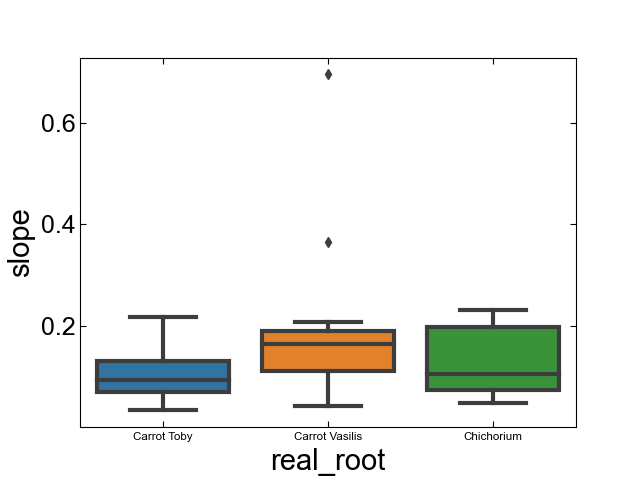

In [30]:
fig, ax = plt.subplots()
select= df[df['FungalSide']=="100P/100N/100C"]
# select= select[select['fungus']=="C2"]

sns.boxplot(select,x = "real_root",y="slope")
ax.set_xticklabels(ax.get_xticklabels(), fontsize='small')  # You can adjust 'small' to a specific number if needed

[Text(0, 0, 'Carrot Toby'),
 Text(1, 0, 'Carrot Vasilis'),
 Text(2, 0, 'Chichorium')]

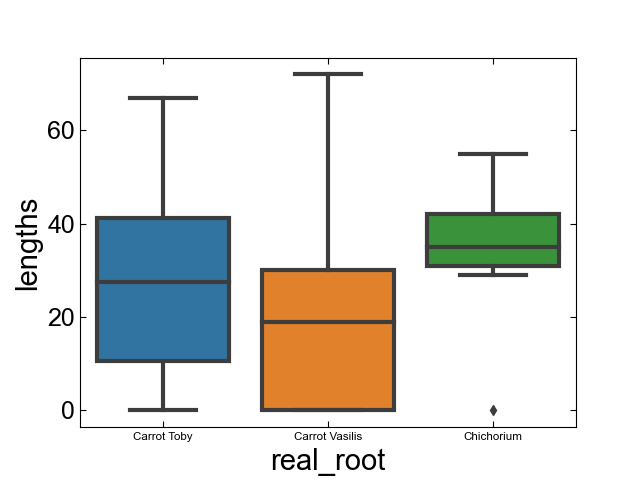

In [31]:
fig, ax = plt.subplots()
select= df[df['FungalSide']=="100P/100N/100C"]
# select= select[select['fungus']=="C2"]

sns.boxplot(select,x = "real_root",y="lengths")
ax.set_xticklabels(ax.get_xticklabels(), fontsize='small')  # You can adjust 'small' to a specific number if needed

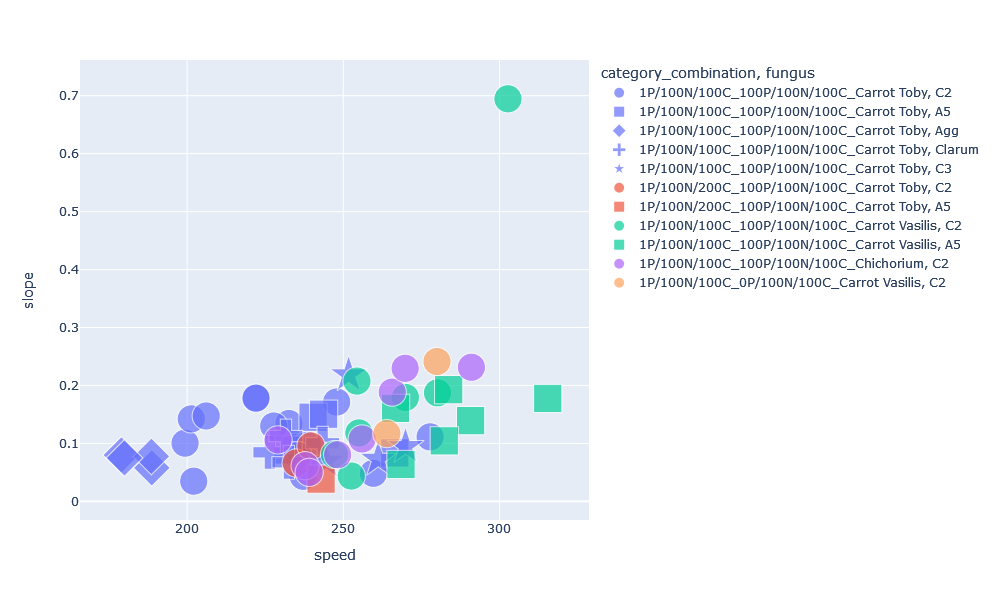

In [32]:
import plotly.express as px
fig = px.scatter(df, x='speed', y='slope', color='category_combination',
                 hover_data=['plate_id',"fungus"], size='size_point', symbol='fungus', symbol_map=marker_symbols)
fig.update_layout(height=600)  # You can change these values as per your preference
# Show the plot
fig.show()

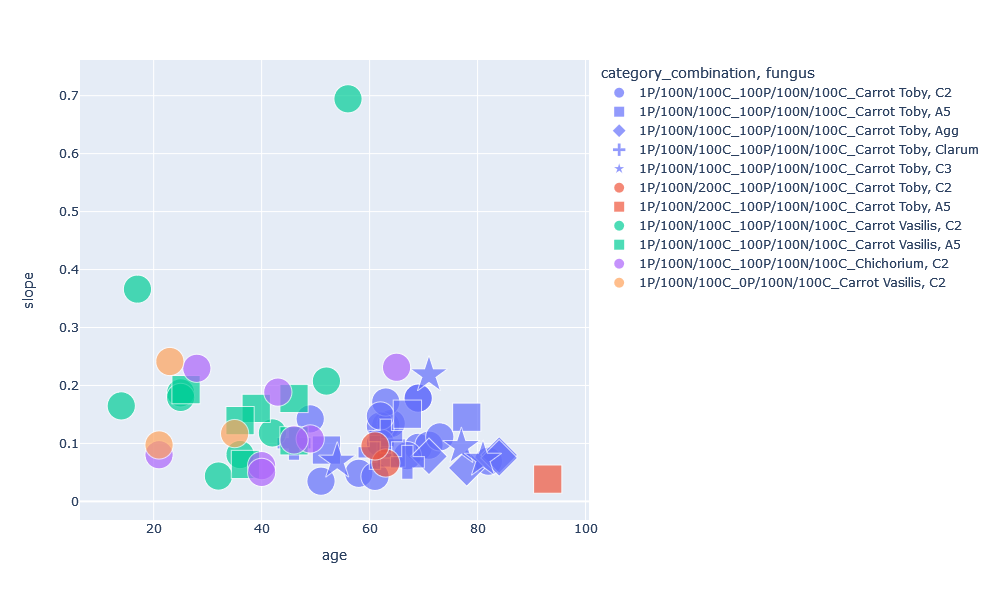

In [33]:
import plotly.express as px
fig = px.scatter(df, x='age', y='slope', color='category_combination',
                 hover_data=['plate_id',"fungus"], size='size_point', symbol='fungus', symbol_map=marker_symbols)
fig.update_layout(height=600)  # You can change these values as per your preference
# Show the plot
fig.show()

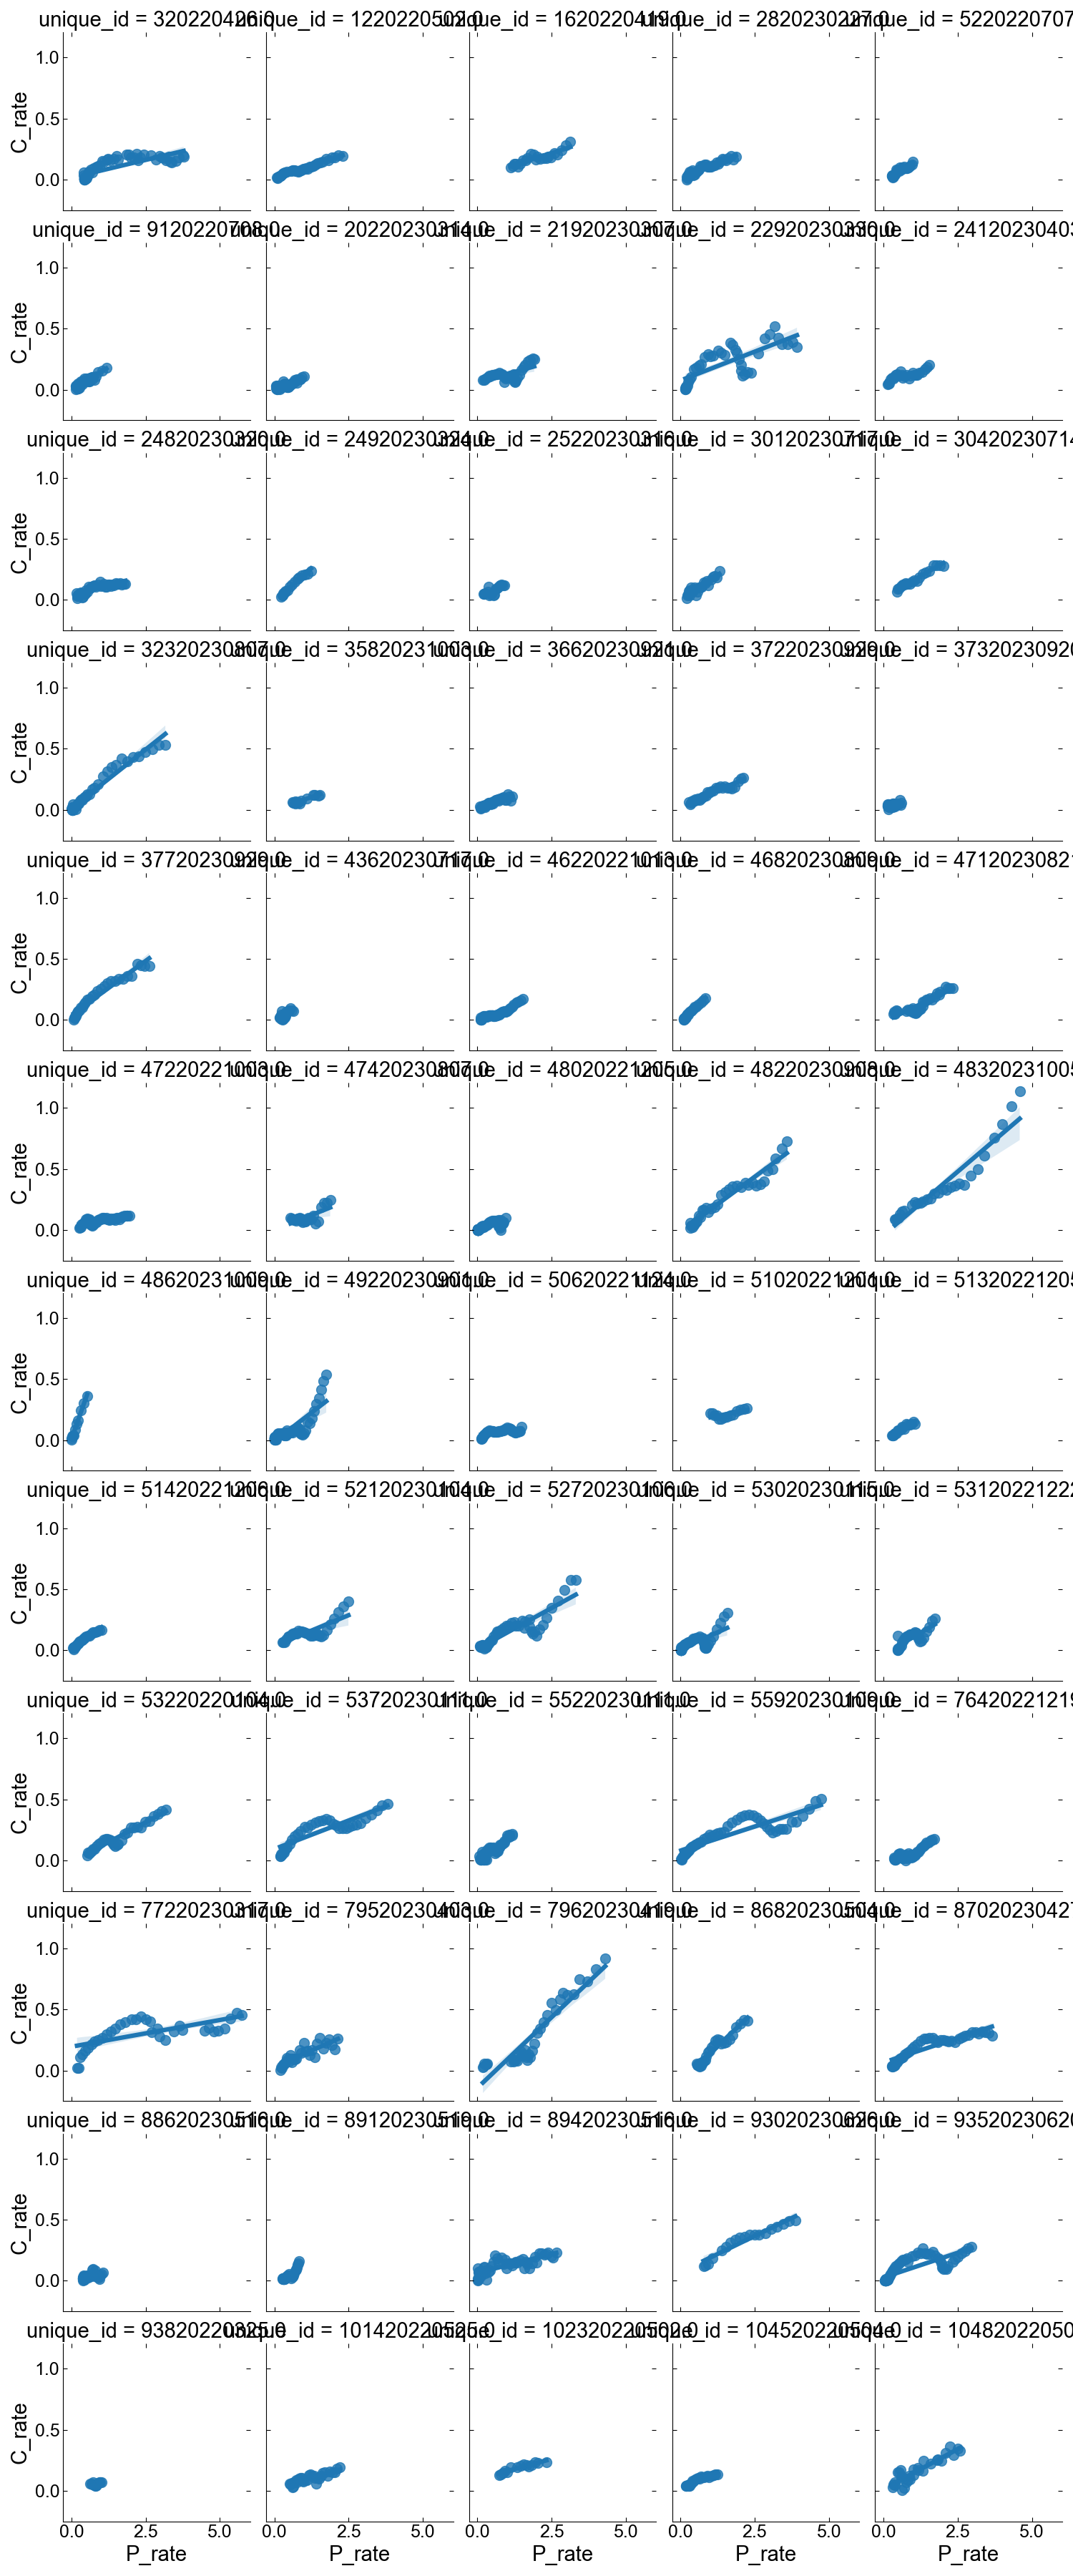

In [34]:
# fig, ax = plt.subplots()
select = select_data
select = select_data[select_data['time_since_begin_h_shifted'] < select_data['time_since_begin_h_shifted_max_c_rate']]
select = select[select['C_rate']>0]

counts = select.groupby("unique_id").count()['C_rate']
ids = counts[counts>10].index
select = select[select['unique_id'].isin(ids)]

g = sns.FacetGrid(select, col="unique_id", col_wrap=5)
g.map_dataframe(sns.regplot, x="P_rate",y='C_rate')

<AxesSubplot: xlabel='P_rate', ylabel='C_rate'>

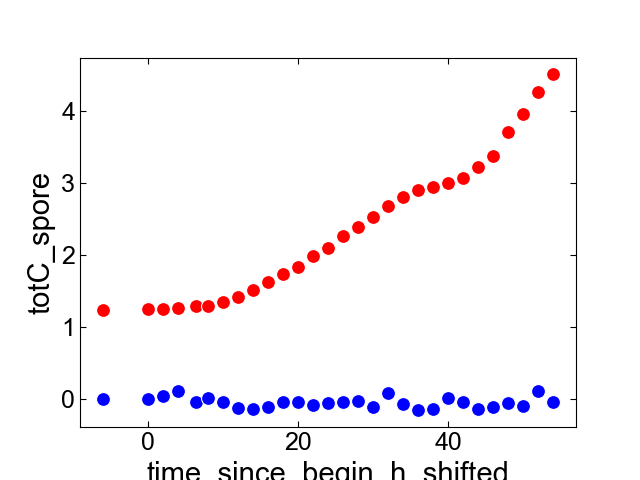

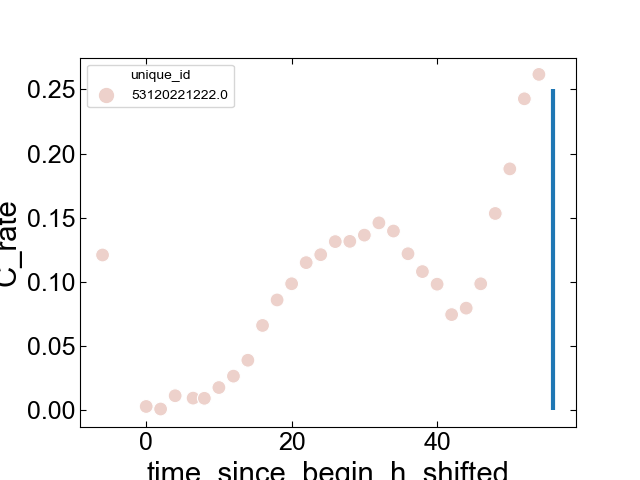

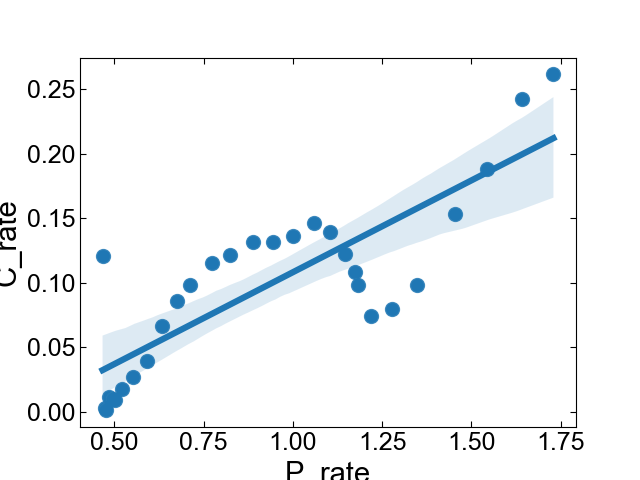

In [35]:
from random import choice
# select = select_data.loc[select_data['time_since_begin_h_shifted']<=tmax]
select = select_data
select = select_data[select_data['time_since_begin_h_shifted'] < select_data['time_since_begin_h_shifted_max_c_rate']]
select = select[select['C_rate']>0]
# select = select[select['acceleration_biovolume']>0]

unique_id = choice(select['unique_id'].unique())
unique_id = 531_20221222

select = select[select['unique_id']==unique_id]
fig, ax = plt.subplots()

sns.scatterplot(data=select,x='time_since_begin_h_shifted',y='totC_spore',color="blue")
sns.scatterplot(data=select,x='time_since_begin_h_shifted',y='totC_hypha',color="red")

fig, ax = plt.subplots()

sns.scatterplot(data=select,x='time_since_begin_h_shifted',y='C_rate',hue="unique_id")
ax.vlines(select["time_since_begin_h_shifted_max_c_rate"].iloc[0],0,0.25)
fig, ax = plt.subplots()

sns.scatterplot(data=select,x='P_rate',y='C_rate')
sns.regplot(data=select,x='P_rate',y='C_rate')